## Meta functions

In [20]:
import random

random.seed(42)


def shuffle_data(dataset: list) -> None:
    random.shuffle(dataset)


def train_test_split(dataset: list, test_percentage: float) -> tuple:
    split_index = int(len(dataset) * test_percentage)
    train, test = dataset[:split_index], dataset[split_index:]
    return train, test

## Data import

In [21]:
import torch
import pandas as pd

df = pd.read_csv('../gitignore_files/iris/iris.data', header=None)

y_names = df.iloc[:, -1].tolist()
y_set = list(set(df.iloc[:, -1].tolist()))
y_dict = {}
for i, v in enumerate(y_set):
    y_dict[v] = i

X = [torch.tensor(row, dtype=torch.float32) for row in df.iloc[:, :4].values]
Y = [torch.tensor(y_dict[element], dtype=torch.long) for element in y_names]

iris_dataset = [(x, y) for x, y in zip(X, Y)]

shuffle_data(iris_dataset)
train_data, test_data = train_test_split(iris_dataset, test_percentage=0.2)




## Model architecture

In [22]:
import torch
from torch import nn


class Model(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_neurons_per_layer: int) -> None:
        super().__init__()

        self.lrelu = nn.LeakyReLU()

        self.layer1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_neurons_per_layer),
            self.lrelu,
            nn.Linear(in_features=hidden_neurons_per_layer, out_features=output_size)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer1(x)


model = Model(input_size=4, output_size=3, hidden_neurons_per_layer=8)

## Training loop

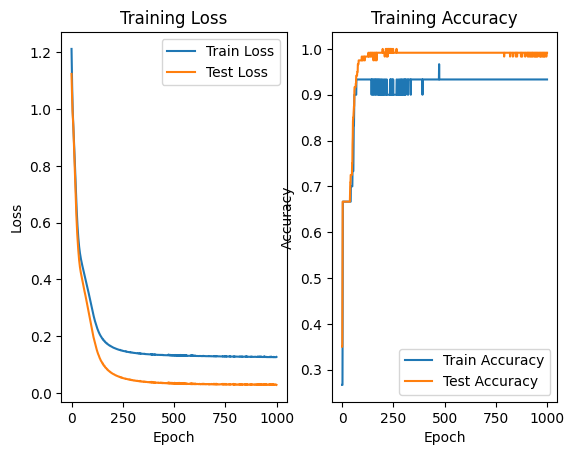

In [23]:
import torch

EPOCHS = 1000
BATCH_SIZE = 16
UPDATE_PARAMS_EVERY_NUM_BATCHES = 2
LEARNING_RATE = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    train_loss, test_loss = 0, 0
    train_accuracy, test_accuracy = 0, 0
    current_batch = 0

    for batch_index, (x_batch, y_batch) in enumerate(train_dataloader):
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        current_batch += 1
        train_loss += (loss.item()) * len(y_batch)
        if current_batch % UPDATE_PARAMS_EVERY_NUM_BATCHES == 0:
            optimizer.step()
            optimizer.zero_grad()
            current_batch = 0

        predictions = torch.argmax(outputs, dim=1)
        for index, prediction in enumerate(predictions):
            if prediction == y_batch[index]:
                train_accuracy += 1

    train_loss_history.append(train_loss / len(train_data))
    train_accuracy_history.append(train_accuracy / len(train_data))

    for batch_index, (x_batch, y_batch) in enumerate(test_dataloader):
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)
        test_loss += (loss.item()) * len(y_batch)

        predictions = torch.argmax(outputs, dim=1)
        for index, prediction in enumerate(predictions):
            if prediction == y_batch[index]:
                test_accuracy += 1

    test_loss_history.append(test_loss / len(test_data))
    test_accuracy_history.append(test_accuracy / len(test_data))

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot losses with labels
ax1.plot(train_loss_history, label='Train Loss')
ax1.plot(test_loss_history, label='Test Loss')
ax1.title.set_text('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracies with labels
ax2.plot(train_accuracy_history, label='Train Accuracy')
ax2.plot(test_accuracy_history, label='Test Accuracy')
ax2.title.set_text('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

